In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score

# Classification Model Using XGBClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# Setting Seed
import random
SEED = 14
np.random.seed(SEED)
random.seed(SEED)

In [3]:
df = pd.read_csv('S3_1_data.csv', encoding = 'utf-8-sig', index_col = 0)

nan_idx = df.loc[pd.isna(df).any(axis=1), :].index
df_original_test = np.log(df.fillna(method='ffill', inplace=False)) - np.log(df.fillna(method='ffill', inplace=False).shift(1))
df_original_test.loc[nan_idx, :] = np.nan
df_original_test.dropna(inplace=True, axis=0)

df_original = df_original_test.copy()

# Making Source Variables
X_df = df_original.drop(['Republic of Korea (KOSPI)'], axis = 1)

# Making Target Variable (KOSPI)
y_df = pd.DataFrame()
y_df_temp = pd.DataFrame(df_original['Republic of Korea (KOSPI)'])
y_df['target'] = [1 if s > 0 else 0 for s in y_df_temp['Republic of Korea (KOSPI)']]
y_df.index = X_df.index
y_df = y_df.shift(-1)
y_df = y_df.dropna()
X_df = X_df.iloc[:-1, :]

In [4]:
# Making Training Sets and Test Sets
threshold_date = "2021-01-01"

X_train = X_df[X_df.index < threshold_date]
X_test = X_df[X_df.index >= threshold_date]
y_train = y_df[y_df.index < threshold_date]
y_test = y_df[y_df.index >= threshold_date]

In [5]:
# Training Defulat XGBClassifier Models
model = XGBClassifier(random_state = SEED)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=14,
              reg_alpha=0, reg_lambda=1, ...)

In [6]:
# Conducting Test and Classification Results
y_pred = pd.DataFrame(model.predict(X_test))
y_score = pd.DataFrame(model.predict_proba(X_test)).round(4)

print(y_test)

y_pred.index = y_test.index
y_score.index = y_test.index
y_result = pd.concat([y_test, y_pred, y_score], axis = 1)

y_result.columns = ['Test Data (Original)', 'Prediction Results', 'Probability of Predicting Bearish Market', 'Probability of Predicting Bullish Market']
y_result.to_csv('classification_results.csv', encoding = 'utf-8-sig')

            target
date              
2021-01-04     1.0
2021-01-05     0.0
2021-01-06     1.0
2021-01-08     0.0
2021-01-12     1.0
...            ...
2021-11-17     0.0
2021-11-18     1.0
2021-11-22     0.0
2021-11-24     0.0
2021-11-26     0.0

[129 rows x 1 columns]


Accuracy is 0.589
F1 Score is 0.649


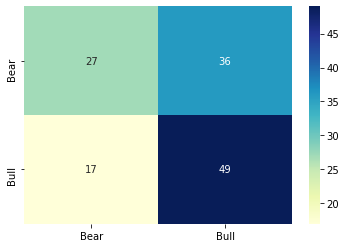

In [7]:
# Performance Evaluation
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, xticklabels = ['Bear', 'Bull'], yticklabels = ['Bear', 'Bull'], cmap="YlGnBu")
plt.savefig('confusion_matrix.png')

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy is " + str(round(accuracy, 3)))
print("F1 Score is " + str(round(f1, 3)))